In [31]:
%pip install nltk
%pip install youtokentome
%pip install keras

Собрала посты со старого Рэддита с количеством голосов

In [32]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import string
import re
from nltk.corpus import stopwords
import nltk
import youtokentome as yttm
from sklearn.model_selection import train_test_split
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as f
from torchsummary import summary
import torchtext
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, SimpleRNN, LSTM, GRU, Bidirectional, Dense, ELU, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model
from keras.initializers import Constant
import numpy as np
from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec

In [33]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
posts = pd.read_csv("results-all.csv")
posts.head()

,text,vote_count
0,Well that backfired,16517
1,Margot the Rescue,12462
2,meirl,6959
3,The new beam attraction in NYC🤯🤯🤯🤯 I am not cu...,12800
4,Nurses/medical staff being bros,14788


In [35]:
posts.sample(5)

,text,vote_count
889,_______ should’ve gotten voted out!,493
5720,[Post Match Thread] Manchester United 2 - 1 Ch...,263
2845,Any love for a nerdy gal?,153
966,Dog-box,430
5196,If BHVR ever gives Chucky more outfits and ski...,454


In [36]:
def replace_punctuation_with_spaces(text):
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    modified_text = text.translate(translator)
    return modified_text



posts.text = posts.text.apply(lambda x: x.lower())
posts.text = posts.text.apply(replace_punctuation_with_spaces)

<Axes: >

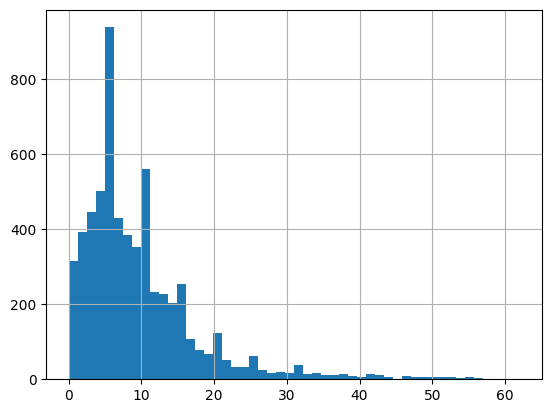

In [37]:
words_n = posts.text.apply(lambda x: len(x.split()))
words_n.hist(bins=50)

Уберем из твитов знаки препинания, смайлики и оставим только слова

In [38]:
posts.head(10)

,text,vote_count
0,well that backfired,16517
1,margot the rescue,12462
2,meirl,6959
3,the new beam attraction in nyc🤯🤯🤯🤯 i am not cu...,12800
4,nurses medical staff being bros,14788
5,new legislation proposes to take wall street o...,12137
6,til while filming the scene in 1983’s “a chris...,11474
7,he has 89 1k followers,23680
8,nice,8377
9,deadass,10632


In [39]:
alphabet = set(list(map(chr, range(97, 123))))
drop_not_letters = lambda s: ''.join(list(filter(lambda c: c in alphabet or c == ' ', s)))

posts.text = posts.text.apply(lambda x: x.lower())
posts.text = posts.text.apply(drop_not_letters)
posts.head(10)

,text,vote_count
0,well that backfired,16517
1,margot the rescue,12462
2,meirl,6959
3,the new beam attraction in nyc i am not curiou...,12800
4,nurses medical staff being bros,14788
5,new legislation proposes to take wall street o...,12137
6,til while filming the scene in s a christmas s...,11474
7,he has k followers,23680
8,nice,8377
9,deadass,10632


Сосчитаем количество уникальных слов

In [40]:
def replace_multiple_spaces_with_single(text):
    return re.sub(r'\s+', ' ', text)
posts.text = posts.text.apply(replace_multiple_spaces_with_single)
posts.head(10)

,text,vote_count
0,well that backfired,16517
1,margot the rescue,12462
2,meirl,6959
3,the new beam attraction in nyc i am not curiou...,12800
4,nurses medical staff being bros,14788
5,new legislation proposes to take wall street o...,12137
6,til while filming the scene in s a christmas s...,11474
7,he has k followers,23680
8,nice,8377
9,deadass,10632


In [41]:
def merge_posts(posts: list[str]) -> str:
    return ' '.join(posts)

unique_words = merge_posts(posts.text).split(' ')
len(unique_words)

60280

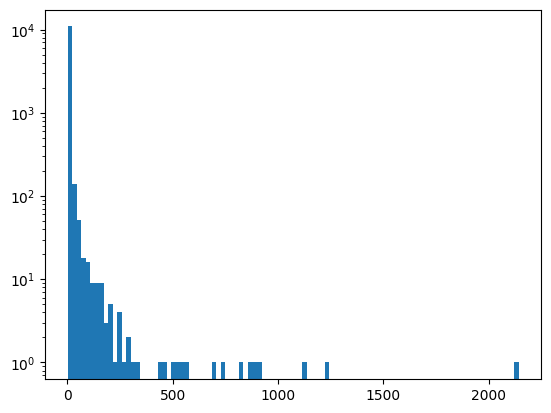

In [42]:
from collections import Counter

counts = Counter(merge_posts(posts.text).split())
freqs = list(counts.values())

plt.hist(freqs, bins=100)
plt.yscale('log')
plt.show()

In [43]:
words = counts.most_common(50000)
most_freq_words = counts.most_common(100)
def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in most_freq_words])

posts.text = posts.text.apply(remove_freqwords)
posts.head(10)

,text,vote_count
0,well that backfired,16517
1,margot the rescue,12462
2,meirl,6959
3,the new beam attraction in nyc i am not curiou...,12800
4,nurses medical staff being bros,14788
5,new legislation proposes to take wall street o...,12137
6,til while filming the scene in s a christmas s...,11474
7,he has k followers,23680
8,nice,8377
9,deadass,10632


In [44]:
words_texts = [word for word, _ in words]

In [45]:
def drop_rare_words(post: str) -> str:
    return " ".join([w for w in post.split() if w in words_texts])

def remove_short_words(text):
    return " ".join([word for word in text.split() if len(word) > 2])

posts.text = posts.text.apply(drop_rare_words)
posts.text = posts.text.apply(remove_short_words)
posts.text.head(10)

0                                  well that backfired
1                                    margot the rescue
2                                                meirl
3       the new beam attraction nyc not curious enough
4                      nurses medical staff being bros
5    new legislation proposes take wall street out ...
6    til while filming the scene christmas story wh...
7                                        has followers
8                                                 nice
9                                              deadass
Name: text, dtype: object

In [46]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

posts["text"] = posts["text"].apply(lambda text: remove_stopwords(text))
posts.head()

,text,vote_count
0,well backfired,16517
1,margot rescue,12462
2,meirl,6959
3,new beam attraction nyc curious enough,12800
4,nurses medical staff bros,14788


Стэмминг

In [47]:
posts = posts[posts.text.apply(lambda x: len(x) > 0)]

In [48]:
from nltk.stem import PorterStemmer
import nltk

stemmer = PorterStemmer()
def stem_words(post):
    return ' '.join(list(map(stemmer.stem, post.split())))

posts.text = posts.text.apply(stem_words)
posts.sample(10)

,text,vote_count
6055,senat republican block fund bill includ aid uk...,184
2818,fli spirit frontier airlin like normal person ...,2196
2231,sweet schnauzer wed day,716
3935,distort ladi verg speak dant,176
3908,upvot comment partit countri neighbour,1129
2037,far worst cover ever seen life,236
3611,wisconsin trump elector settl lawsuit agre biden,1451
5008,gop activist villag found guilti elect voter f...,462
3282,train even seven,705
115,rememb kid technolog firepow win battl logist ...,14498


Код для тренировки модели

In [49]:

seq_length = posts.text.apply(lambda x: len(x.split())).max()
embedding_vecor_length = 300
MAX_EPOCHS = 30


In [50]:
def train_bpe_model(temp_dataset_file, records, model_path, model_type="bpe", vocab_size=8000):
    with open(temp_dataset_file, "w") as temp:
        for record in records:
            temp.write(record + "\n")
    yttm.BPE.train(data=temp_dataset_file, vocab_size=vocab_size, model=model_path, coverage=1)

train_bpe_model("temp_posts.txt", posts.text, "bpe_model.bin")
bpe_model = yttm.BPE('bpe_model.bin')


In [51]:
sentences = bpe_model.encode(posts.text.tolist(), output_type=yttm.OutputType.SUBWORD, eos=True)

w2v_model = Word2Vec(
    min_count = 1,
    vector_size=300,
    window = 2,
    sample=6e-5,
    alpha=0.03,
    min_alpha=0.0007,
    negative=15,
    workers=4
)

w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=10, report_delay=1)

(256997, 442800)

In [52]:
w2v_vectors = np.zeros((bpe_model.vocab_size(), w2v_model.vector_size))
for i, word in enumerate(bpe_model.vocab()):
  if word in w2v_model.wv.key_to_index:
    w2v_vectors[i] = w2v_model.wv.get_vector(word)
  else:
    w2v_vectors[i] = np.zeros(w2v_model.vector_size)

In [53]:
X_origin, y_origin = posts.text, posts.vote_count

In [54]:
X, y = posts.text, posts.vote_count

X = bpe_model.encode(X.tolist())
X = sequence.pad_sequences(X, maxlen=seq_length, padding="post")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [55]:
filepath = "model.keras"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)

In [71]:
import keras.losses as losses
import keras.metrics as metrics
import keras.constraints as constrainrs
model = Sequential()
embedding = Embedding(bpe_model.vocab_size(), 100, mask_zero=True, trainable=True)
model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(GRU(50)))
model.add(Dense(150, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(62, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(31, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss = 'huber', optimizer='adam', metrics=['mape', 'mae', metrics.RootMeanSquaredError()])

# model.build(input_shape=(seq_length,))
model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test),
    callbacks=[ckpt, rlp], epochs=1
)

# embedding.set_weights([np.array(w2v_vectors)])

model.summary()
plot_model(model, show_shapes=True)

history = model.fit(x=X_train, y=y_train, validation_split=0.2,
    callbacks=[ckpt, rlp], epochs=MAX_EPOCHS
)

150/150 [==============================] - ETA: 0s - loss: 1102.6840 - mape: 106.8445 - mae: 1103.1837 - root_mean_squared_error: 2607.9827
Epoch 1: loss did not improve from 506.83585
150/150 [==============================] - 22s 85ms/step - loss: 1102.6840 - mape: 106.8445 - mae: 1103.1837 - root_mean_squared_error: 2607.9827 - val_loss: 990.8107 - val_mape: 112.7644 - val_mae: 991.3107 - val_root_mean_squared_error: 2735.9983 - lr: 0.0010
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 100)         800000    
                                                                 
 spatial_dropout1d_6 (Spati  (None, None, 100)         0         
 alDropout1D)                                                    
                                                                 
 bidirectional_6 (Bidirecti  (None, 100)               45600     
 on

In [72]:
def plot_model_learning(history, title):
    fig, ax = plt.subplots(4, 1, figsize=(20, 15))
    df = pd.DataFrame(history.history)
    df[['mape', 'val_mape']].plot(ax=ax[0])
    df[['loss', 'val_loss']].plot(ax=ax[1])
    df[['mae', 'val_mae']].plot(ax=ax[2])
    df[['root_mean_squared_error', 'val_root_mean_squared_error']].plot(ax=ax[3])
    ax[0].set_title('Model MAPE', fontsize=12)
    ax[1].set_title('Model Loss', fontsize=12)
    ax[2].set_title('Model MAE', fontsize=12)
    ax[3].set_title('Model RMSE', fontsize=12)
    fig.suptitle(f'{title}: Model Metrics', fontsize=18)

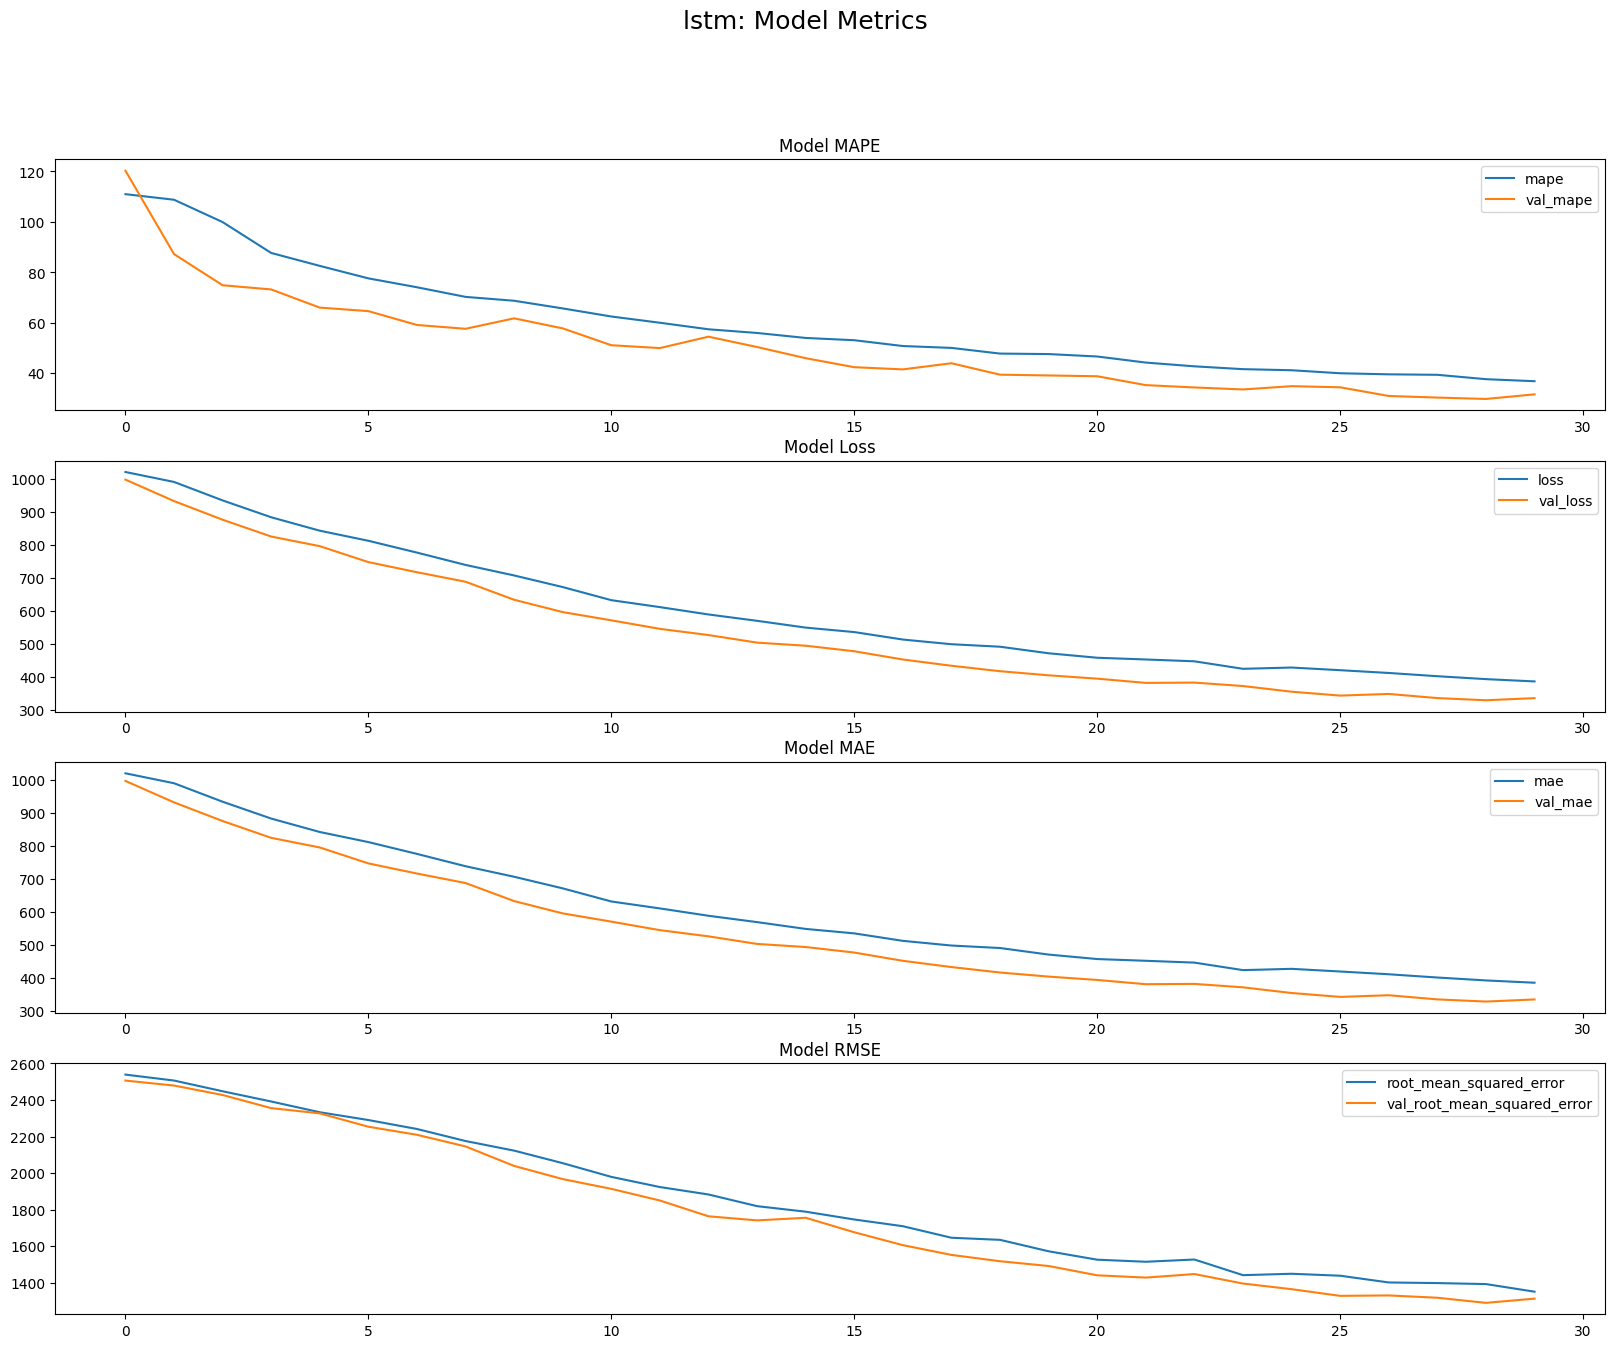

In [73]:
plot_model_learning(history, "lstm")

In [59]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)


150/150 [==============================] - 1s 5ms/step


In [60]:
y_pred_test

array([[  83.64515],
       [ 213.91841],
       [ 896.7852 ],
       ...,
       [ 132.36972],
       [ 177.05614],
       [1905.1871 ]], dtype=float32)

Примеры предсказаний на train

In [ ]:
for i in range(100, 103):
    print("Text: ",  bpe_model.decode(X_train[i].tolist())[0].replace("<PAD>", ""))
    print("y_pred_train", int(y_pred_train[i]))
    print("y_train:", y_train.iloc[i])
    print("-----")

Text:  day
y_pred_train 250
y_train: 202
-----
Text:  say wors salt bae steak
y_pred_train: 12101
y_train: 19342
-----
Text:  elizabeth olsen
y_pred_train: 137
y_train: 105
-----


Примеры предсказаний на test

In [ ]:
for i in range(100, 103):
    print("Text: ",  bpe_model.decode(X_test[i].tolist())[0].replace("<PAD>", ""))
    print("y_pred_test:", int(y_pred_test[i]))
    print("y_test:", y_test.iloc[i])
    print("-----")


Text:  ohio state chip trayanum enter transfer portal
y_pred_test: 401
y_test: 442
-----
Text:  like dragon monkey ball new substori drop
y_pred_test: 1572
y_test: 1375
-----
Text:  give kind thing dp thrill
y_pred_test: 980
y_test: 970
-----
